# l-1 trend filtering (18 pts)

В своей знаменитой статье [l-1 trend filtering](https://web.stanford.edu/~boyd/papers/l1_trend_filter.html) Стивен Бойд и его коллеги предложили подход к выявлению тренда в финансовых временных рядах с помощью выпуклой оптимизации. В частности, вместо построения стохастической модели временного ряда, они предложили отталкиваться от задачи - построить кусочно-линейную линию тренда, наилучшим образом аппроксимирующую данный временной ряд.

Это привело к задачи оптимизации следующего вида:

**TrendFilter problem**
$$
\min_{x \in R^T} \frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1
$$
где $y \in R^T$ - временной ряд фактических цен акции (с момента времени $t = 1$ до момента времени $T$), матрица $D \in R^{(T-2) \times T}$ является трехдиагональной: $[Dx]_i = x_i - 2 \cdot x_{i+1} + x_{i+2} \quad$ ($1\leq i \leq T-2$).

Первый член в целевой функции отвечает за близость решения к фактическим данным, а второй форсирует решение  быть кусочно-линейной функцией с минимальным числом "изломов". 

Задание:
1. (1 pts.) Скачайте тестовые данные: данные о цене закрытия акций российских финансовых компаний (например, с finam.ru). Это ваши тестовые данные. 
2. (3 pts.) Выпишите двойственную задачу для задачи Trend Filter.
3. (3 pts.) Численно решите задачу Trend Filter используя одну из версий проксимального градиентного спуска.
4. (5 pts.) Выпишите сглаженную версию задачи Trend Filter и найдите ее решение используя метод быстрого градиентного спуска (версия из лекции про сглаживание).
5. (4 pts.) Выпишите схему ADMM для решения задачи Trend Filter, реализуйте ее и найдите численное решение задачи. 
6. (2 pts.) Сравните полученные результаты на тестовых данных.

# 1.

In [1]:
import yfinance as yf
import numpy as np 
import matplotlib.pyplot as plt
import scipy.linalg as splin

In [2]:
eqw = yf.download('GAZP.ME','2010-01-01','2021-01-01')['Adj Close']
eqw.tail()

[*********************100%***********************]  1 of 1 completed


Date
2020-12-24    196.395081
2020-12-25    196.701447
2020-12-28    197.132248
2020-12-29    200.109680
2020-12-30    203.316864
Name: Adj Close, dtype: float64

In [3]:
y = eqw.values
T = len(eqw)

In [4]:
D = np.zeros((T-2)*T).reshape(T-2, T)
for i in range(T-2):
    D[i][i] = 1
    D[i][i+1] = -2
    D[i][i+2] = 1

# 2.

$$
\min_{x \in R^T} \frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1
$$ 
Сделаем замену $z = Dx$ и получим задачу:
$$
\min_{x \in R^T} \frac{1}{2}\|y - x\|_2^2 + \lambda \|z\|_1
$$ 
$$
z = Dx.
$$
$$
L(x, z,\nu) = \frac{1}{2}\|y-x\|^2_2 + \lambda\|z\|_1 + \nu^T(Dx-z).
$$
Отсюда 
$$
g(\nu) = \inf_{x,z} L(x,z,\nu)
$$
Заметим, что 
$$
- \lambda \textbf{1} \le \nu \le \lambda \textbf{1},
$$
иначе $\inf_{x,z} L(x,z,\nu) = -\infty.$ 

Тогда в этом случае 
$$
\inf_{x,z} L(x,z,\nu) = \inf_{x} \Big(\frac{1}{2}\|y-x\|^2_2 + \nu^TDx \Big)
$$
$$
\Big(\frac{1}{2}\|y-x\|^2_2 + \nu^TDx \Big)' = -(y - x) + D^T\nu = 0.
$$
$$
x = y - D^T\nu.
$$
$$
\inf_{x,z} L(x,z,\nu) = \frac{1}{2}\|y-y + D^T\nu\|^2_2 + \nu^TD(y - D^T\nu) = -\frac{1}{2}\nu^TDD^T\nu + \nu^TD y.
$$
Получаем двойственную задачу:
$$
(D)\quad \max_{\nu} -\frac{1}{2}\nu^TDD^T\nu + \nu^TD y.
$$
$$
- \lambda \textbf{1} \le \nu \le \lambda \textbf{1}.
$$
или 
$$
(D)\quad \min_{\nu} \frac{1}{2}\nu^TDD^T\nu - \nu^TD y.
$$
$$
- \lambda \textbf{1} \le \nu \le \lambda \textbf{1}.
$$

# 3. Prox Grad Descent

Заметим, что двойcтвенную задачу из пункта 2. можно переписать следующим образом:

$$
\min_{\nu} \frac{1}{2}\nu^TDD^T\nu - \nu^TD y + I_{[- \lambda \textbf{1}, \lambda \textbf{1}]}(\nu) =\min_{\nu} h(\nu) + g(\nu). 
$$
$$
h(\nu) = \frac{1}{2}\nu^TDD^T\nu - \nu^TD y,\ g(\nu) = I_{[- \lambda \textbf{1}, \lambda \textbf{1}]}(\nu).
$$
$$
prox_{\mu,g}(v) = \arg\min_{\theta}\Big(\frac{\mu}{2} \|\theta - v \|^2_2 +  I_{[- \lambda \textbf{1}, \lambda \textbf{1}]}(\theta)\Big) = \arg\min_{\theta}\Big(\frac{\mu}{2} \|\theta - v \|^2_2 +  I_{[- \lambda \textbf{1}, \lambda \textbf{1}]}(\theta)\Big) 
$$
$$
\arg\min_{\theta_i}\Big(\frac{\mu}{2} (\theta_i - v_i)^2 +  I_{[- \lambda, \lambda]}(\theta_i)\Big) = \arg\min_{- \lambda \le\theta_i \le  \lambda}\Big(\frac{\mu}{2} (\theta_i - v_i)^2\Big) = \Pr_{- \lambda \le\theta_i \le \lambda} (v_i).
$$
$$
\Pr_{- \lambda \le\theta_i \le \lambda} (v_i) = \begin{cases}
\lambda,\ v_i > \lambda,\\
-\lambda,\ v_i <- \lambda, \\
v_i,\ v_i \in [-\lambda, \lambda]
\end{cases}
$$

Отсюда 
$$
prox_{\mu,g}(v)= (\Pr_{- \lambda \le\theta_1 \le \lambda} (v_1), \Pr_{- \lambda \le\theta_2 \le \lambda} (v_2), \dots, \Pr_{- \lambda \le\theta_{T-2} \le \lambda} (v_{T-2})).
$$
$$
\nu_{t+1} = prox_{\mu,g}(\nu_t - \frac{1}{\mu} \nabla f(\nu_t)).
$$

In [5]:
inf = 10**9
lam = 1
max_iter = 1000
alpha = 1e-2

In [6]:
D_ = lambda x: x[:-2] - 2*x[1:-1] + x[2:]

In [7]:
D_T = lambda x: np.hstack([x[0],-2*x[0]+x[1], x[:-2] - 2*x[1:-1] + x[2:], x[-2]-2*x[-1], x[-1]])

In [8]:
f_new = lambda nu: 0.5 * D_T(nu) @ D_T(nu) - nu @ D_(y) + np.maximum(np.zeros_like(nu), np.abs(nu) - lam) * inf
h_grad = lambda nu: D_(D_T(nu)) - D_(y)
g_prox = lambda nu: np.minimum(np.abs(nu), lam) * np.sign(nu)
f_old = lambda x: 0.5 * np.linalg.norm((x - y))**2 + lam * np.linalg.norm(D_(x), 1)

In [15]:
def prox_grad_method(nu0, alpha, num_iter, h_grad, g_prox, accel):
    conv = [nu0.copy()]
    nu = nu0.copy()
    if accel:
        mu = nu0.copy()
    for i in range(num_iter):
        if accel:
            nu_next = g_prox(mu - alpha * h_grad(mu))
            mu = nu_next + (i+1) / (i+4) * (nu_next - nu)
            nu = nu_next.copy()
            x = y - D_T(nu)
        else:
            nu = g_prox(nu - alpha * h_grad(nu))
            x = y - D_T(nu)
        conv.append(x.copy())
    return x, conv

In [10]:
nu0 = np.random.randn(T-2)

In [11]:
x_ista, conv_ista = prox_grad_method(nu0, alpha, max_iter, h_grad, g_prox, False)

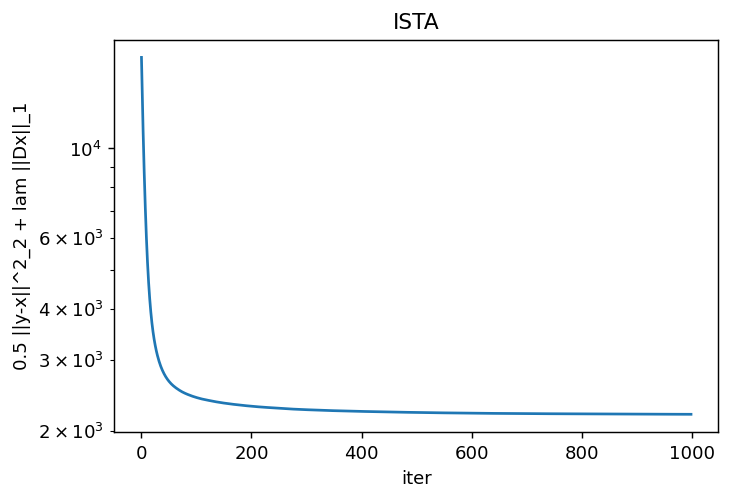

In [12]:
plt.figure(figsize = (6, 4), dpi = 130)
plt.semilogy([f_old(x) for x in conv_ista[1:]])
plt.ylabel("0.5 ||y-x||^2_2 + lam ||Dx||_1")
plt.xlabel("iter")
plt.title("ISTA")
plt.show()

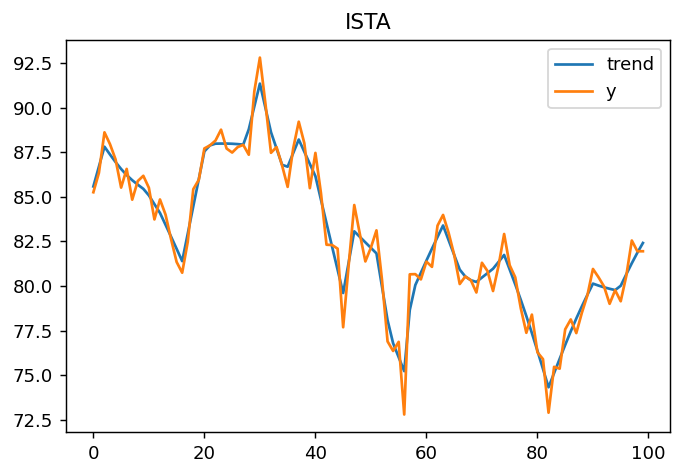

In [13]:
plt.figure(figsize = (6, 4), dpi = 130)
plt.plot(x_ista[:100], label = "trend")
plt.plot(y[:100], label = "y")
plt.title("ISTA")
plt.legend()
plt.show()

In [16]:
x_fista, conv_fista = prox_grad_method(nu0, alpha, max_iter, h_grad, g_prox, True)

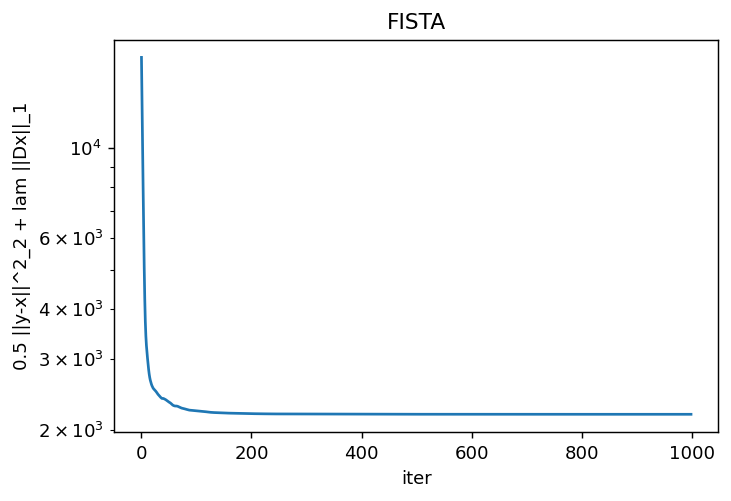

In [17]:
plt.figure(figsize = (6, 4), dpi = 130)
plt.semilogy([f_old(x) for x in conv_fista[1:]])
plt.ylabel("0.5 ||y-x||^2_2 + lam ||Dx||_1")
plt.xlabel("iter")
plt.title("FISTA")
plt.show()

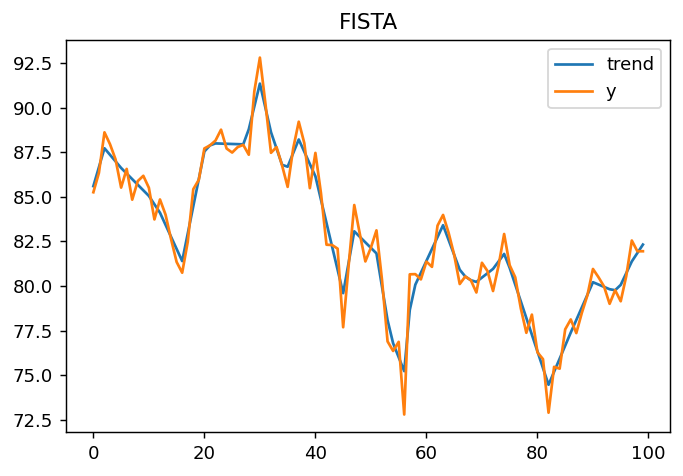

In [18]:
plt.figure(figsize = (6, 4), dpi = 130)
plt.plot(x_fista[:100], label = "trend")
plt.plot(y[:100], label = "y")
plt.title("FISTA")
plt.legend()
plt.show()

# 4. Сглаживание по Нестерову

Представим $$f(x):=\frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1 = \frac{1}{2}\|y - x\|_2^2 + \|\tilde Dx\|_1,$$ где $\tilde D = \lambda D$ в виде $g(x) + h(x)$, где $g(x)$ гладкая выпуклая, а $h(x)$ негладкая выпуклая и представима в виде
$$\max_{u\in Q_2}{x^TA^Tu - \phi(u)}.$$ 
$$
g(x) = \frac{1}{2}\|y - x\|_2^2,\quad h(x) = \|\tilde Dx\|_1.
$$
$h(x)$ представима в виде:
$$h(x)=\max_{u\in [-1,1]^{T-2}}\left(x^T \tilde D^T u \right).$$
Тогда 
$$
h_{\mu}(x) = \max_{u\in [-1,1]^{T-2}}\left(x^T \tilde D^T u - \frac{\mu}{2}\|u \|^2_2\right) = \sum_{i=1}^{T-2}\max_{u_i\in [-1,1]}[\tilde Dx]_i u_i - \frac{\mu}{2}u_i^2= \sum_{i=1}^{T-2} 
\begin{cases}
\frac{[\tilde Dx]^2_i}{2\mu},\ |[\tilde Dx]_i|\le \mu, \\
|[\tilde Dx]_i| - \frac{\mu}{2},\ |[\tilde Dx]_i| > \mu. \\
\end{cases}
$$
$$
h_{\mu}(x)' = \tilde D^Tu^*(x)
$$
Заменим $h(x)$ на $h_{\mu}(x).$ и применим ускоренный градиентный спуск

In [22]:
lam = 10
max_iter = 1000
alpha = 1e-2

In [23]:
def h_mu(x, alpha):
    muu = 1/alpha
    v = lam * D_(x)
    mask = v <= muu
    v[mask] = v[mask] ** 2 / (2 * muu)
    v[~mask] = np.abs(v[~mask]) - muu / 2
    return np.sum(v)

In [24]:
def h_mu_grad(x,alpha):
    muu = 1/alpha
    v = lam * D_(x)
    mask1 = v > muu
    mask2 = v < -muu
    mask3 = np.abs(v) <= muu
    v[mask1] = 1
    v[mask2] = -1
    v[mask3] = v[mask3] / muu
    return lam * D_T(v)

In [25]:
f = lambda x, alpha: 0.5 * (y-x) @ (y-x) + h_mu(x, alpha)

In [26]:
f_grad = lambda x, alpha: x - y + h_mu_grad(x, alpha)

In [27]:
def gradient_descent(f_grad, x0, num_iter, alpha):
    conv = [x0.copy()]
    x = x0.copy()
    for i in range(num_iter):
        x = x - alpha * f_grad(x, alpha)
        conv.append(x.copy())
    return x, conv

In [28]:
def nag(f_grad, x0, num_iter, alpha, restart):
    conv = [x0.copy()]
    x = x0.copy()
    z = x0.copy()
    x_prev = x0.copy()
    for i in range(num_iter):
        x = z - alpha * f_grad(z, alpha)
        if restart:
            if f(x, alpha) > f(x_prev, alpha):
                z = x_prev.copy()
                continue
        z = x + (i+1) / (i+4) * (x - x_prev)
        x_prev = x.copy()
        conv.append(x.copy())
    return x, conv

In [29]:
x0 = np.random.randn(T)

In [30]:
x_nag, conv_nag = nag(f_grad, x0, max_iter, alpha, False)

In [31]:
x_nag_rest, conv_nag_rest = nag(f_grad, x0, max_iter, alpha, True)

In [32]:
x_gd, conv_gd = gradient_descent(f_grad, x0, max_iter, alpha)

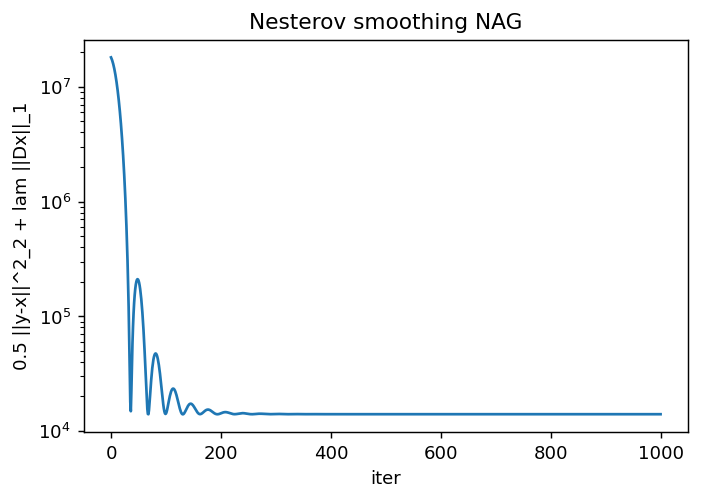

In [34]:
plt.figure(figsize = (6, 4), dpi = 130)
plt.semilogy([f_old(x) for x in conv_nag[1:]])
plt.ylabel("0.5 ||y-x||^2_2 + lam ||Dx||_1")
plt.xlabel("iter")
plt.title("Nesterov smoothing NAG")
plt.show()

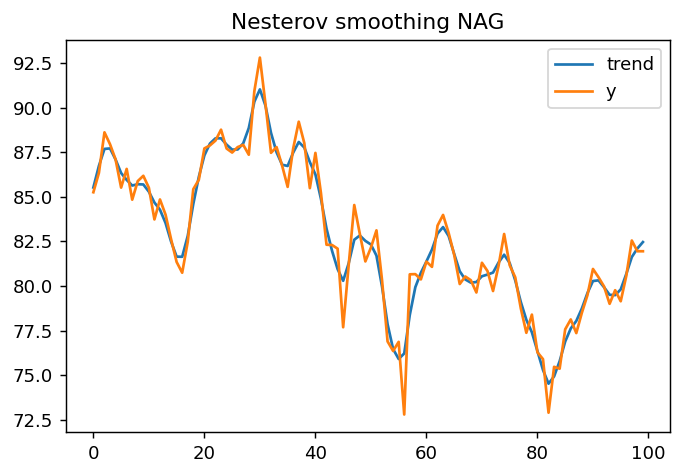

In [36]:
plt.figure(figsize = (6, 4), dpi = 130)
plt.plot(x_nag[:100], label = "trend")
plt.plot(y[:100], label = "y")
plt.title("Nesterov smoothing NAG")
plt.legend()
plt.show()

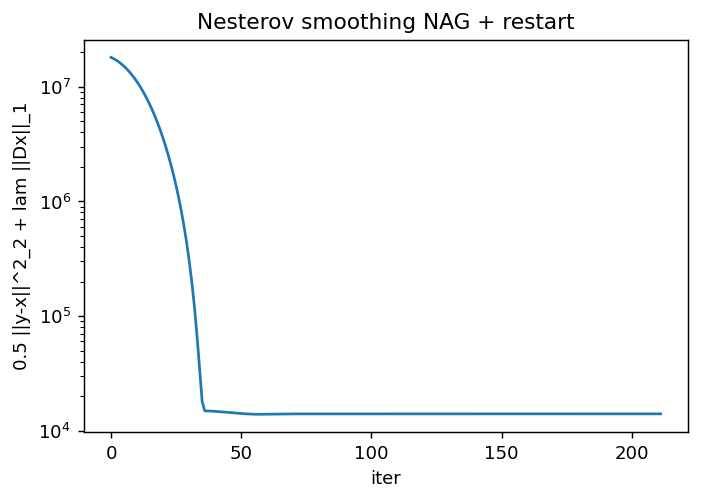

In [37]:
plt.figure(figsize = (6, 4), dpi = 130)
plt.semilogy([f_old(x) for x in conv_nag_rest[1:]])
plt.ylabel("0.5 ||y-x||^2_2 + lam ||Dx||_1")
plt.xlabel("iter")
plt.title("Nesterov smoothing NAG + restart")
plt.show()

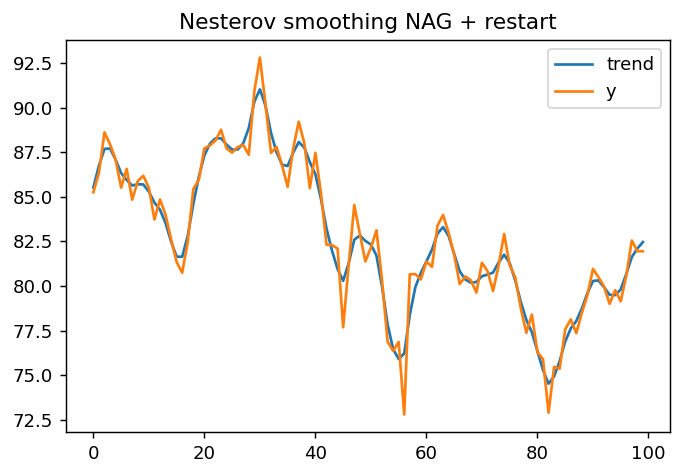

In [40]:
plt.figure(figsize = (6, 4), dpi = 130)
plt.plot(x_nag_rest[:100], label = "trend")
plt.plot(y[:100], label = "y")
plt.title("Nesterov smoothing NAG + restart")
plt.legend()
plt.show()

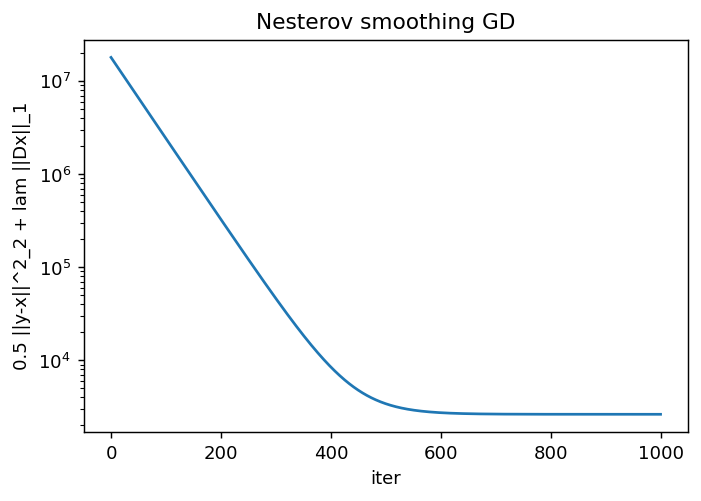

In [57]:
plt.figure(figsize = (6, 4), dpi = 130)
plt.semilogy([f_old(x) for x in conv_gd[1:]])
plt.ylabel("0.5 ||y-x||^2_2 + lam ||Dx||_1")
plt.xlabel("iter")
plt.title("Nesterov smoothing GD")
plt.show()

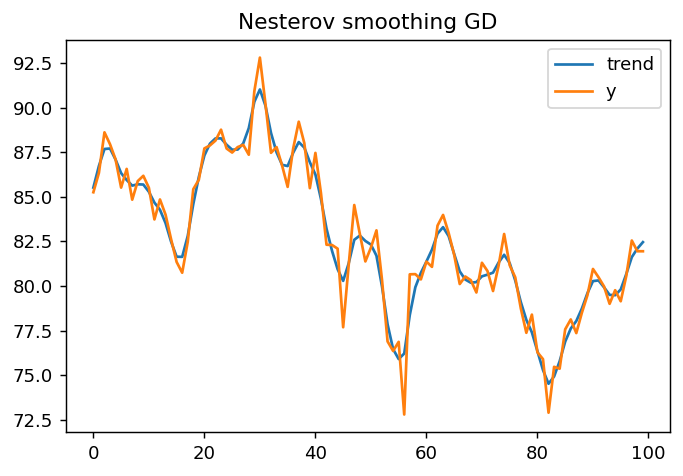

In [58]:
plt.figure(figsize = (6, 4), dpi = 130)
plt.plot(x_gd[:100], label = "trend")
plt.plot(y[:100], label = "y")
plt.title("Nesterov smoothing GD")
plt.legend()
plt.show()

# 5. ADMM

Реализуем ADMM для полученной двойственной задачи

$$
\min_{\nu} \frac{1}{2}\nu^TDD^T\nu - \nu^TD y + I_{[- \lambda \textbf{1}, \lambda \textbf{1}]}(\nu).
$$
Во-первых, она эквивалентна следующей:
$$
\min_{\nu,\ u} \frac{1}{2}\nu^TDD^T\nu - \nu^TD y + I_{[- \lambda \textbf{1}, \lambda \textbf{1}]}(u) = \min_{\nu,\ u} h(\nu) + g(u),
$$
$$
\nu = u.
$$
$$
h(\nu) = \frac{1}{2}\nu^TDD^T\nu - \nu^TD y,\quad g(u) = I_{[- \lambda \textbf{1}, \lambda \textbf{1}]}(u).
$$



Для неё модифицированный лагранжиан примет вид

$$
L_{r}(v, u, \mu) = \frac{1}{2} \|D^T\nu\|_2^2 - \nu^TD y + I_{[- \lambda \textbf{1}, \lambda \textbf{1}]}(u) + \mu^T(\nu - u) + \frac{r}{2}\|\nu - u\|_2^2 = \frac{1}{2} \|D^T\nu\|_2^2 - \nu^TD y + I_{[- \lambda \textbf{1}, \lambda \textbf{1}]}(u) + \frac{r}{2}\|\nu - u + \frac{\mu}{r}\|_2^2 - \frac{\|\mu\|_2^2}{2r}.
$$

\begin{align*}
& \nu^{t+1} = \arg\min_{\nu} L_{r}(\nu, u^t, \mu^t) = prox_{r,h}(u^t - \frac{\mu^t}{r})\\
& u^{t+1} = \arg\min_u L_{r}(\nu^{t+1}, u, \mu^t) = \Pr_{[-\lambda \textbf{1},\lambda \textbf{1}]} (\nu^{t+1} +\frac{\mu^t}{r} )\\
& \mu^{t+1} = \mu^t + r (\nu^{t+1} - u^{t+1})
\end{align*}

$$
prox_{r,h}(x) = \arg\min_{\nu}\frac{1}{2} \|D^T\nu\|_2^2 - \nu^TD y + \frac{r}{2}\|x - \nu\|_2^2
$$
$$
\Big(\frac{1}{2} \|D^T\nu\|_2^2 - \nu^TD y + \frac{r}{2}\|x - \nu\|_2^2 \Big)'= DD^T\nu -Dy - r(x-\nu) = 0
$$
$$
\nu = (DD^T + rI)^{-1}(Dy + rx)
$$
$$
prox_{r,h}(u^t - \frac{\mu^t}{r}) = (DD^T + rI)^{-1}(Dy + r(u^t - \frac{\mu^t}{r}))
$$

In [42]:
lam = 1
max_iter = 1000
alpha = 1e-2

In [43]:
proj = lambda x: np.minimum(np.abs(x), lam) * np.sign(x)

In [44]:
def admm(r0, nu0, u0, mu0, max_iter):
    nu = nu0.copy()
    u = u0.copy()
    mu = mu0.copy()
    conv = [nu]
    r = r0
    
    n = nu.shape[0]
    lu_factor = splin.lu_factor(D @ D.T + r * np.eye(n))
    
    for i in range(max_iter):
        nu = splin.lu_solve(lu_factor, D_(y) + r*(u - mu/r))
        u = proj(nu + mu/r)
        mu = mu + r * (nu - u)
        x = y - D_T(nu)
        conv.append(x.copy())
    return x, conv

In [45]:
u0 = np.random.randn(T-2)
mu0 = np.random.randn(T-2)
r = 1/alpha

In [46]:
x_admm, conv_admm = admm(r, nu0, u0, mu0, max_iter)

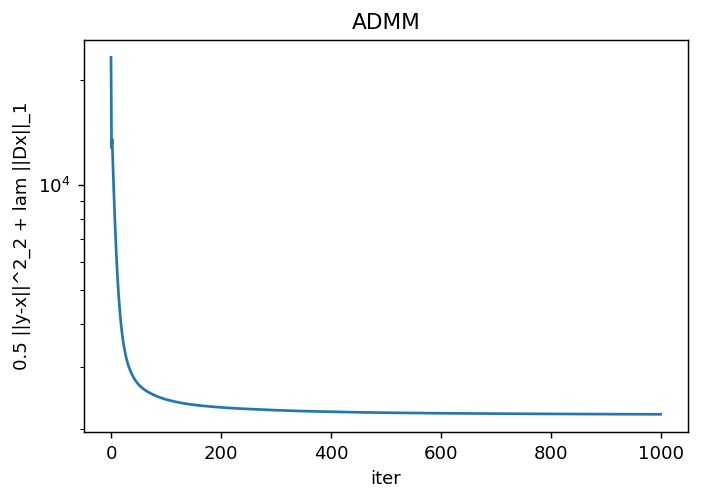

In [47]:
plt.figure(figsize = (6, 4), dpi = 130)
plt.semilogy([f_old(x) for x in conv_admm[1:]])
plt.ylabel("0.5 ||y-x||^2_2 + lam ||Dx||_1")
plt.xlabel("iter")
plt.title("ADMM")
plt.show()

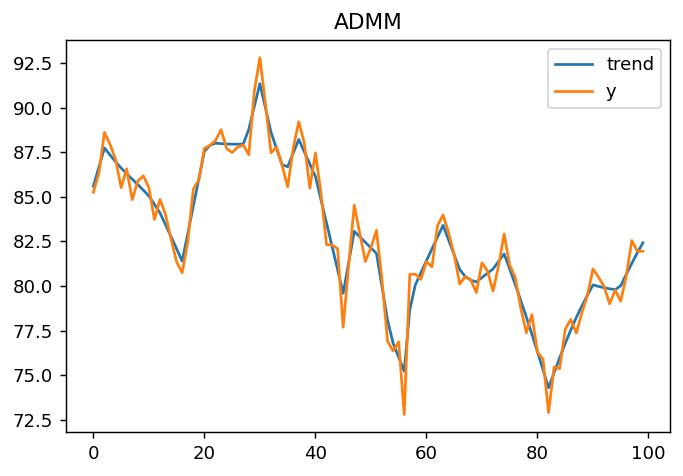

In [48]:
plt.figure(figsize = (6, 4), dpi = 130)
plt.plot(x_admm[:100], label = "trend")
plt.plot(y[:100], label = "y")
plt.title("ADMM")
plt.legend()
plt.show()

# 6. Сравнение алгоритмов

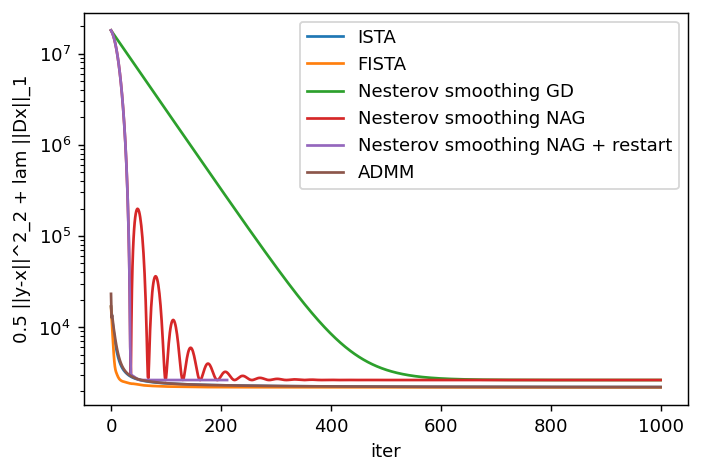

In [61]:
plt.figure(figsize = (6, 4), dpi = 130)
plt.semilogy([f_old(x) for x in conv_ista[1:]], label = "ISTA")
plt.semilogy([f_old(x) for x in conv_fista[1:]], label = 'FISTA')
plt.semilogy([f_old(x) for x in conv_gd[1:]], label = "Nesterov smoothing GD")
plt.semilogy([f_old(x) for x in conv_nag[1:]], label = "Nesterov smoothing NAG")
plt.semilogy([f_old(x) for x in conv_nag_rest[1:]], label = "Nesterov smoothing NAG + restart")
plt.semilogy([f_old(x) for x in conv_admm[1:]], label = "ADMM")

plt.ylabel("0.5 ||y-x||^2_2 + lam ||Dx||_1")
plt.xlabel("iter")
plt.legend()
plt.show()

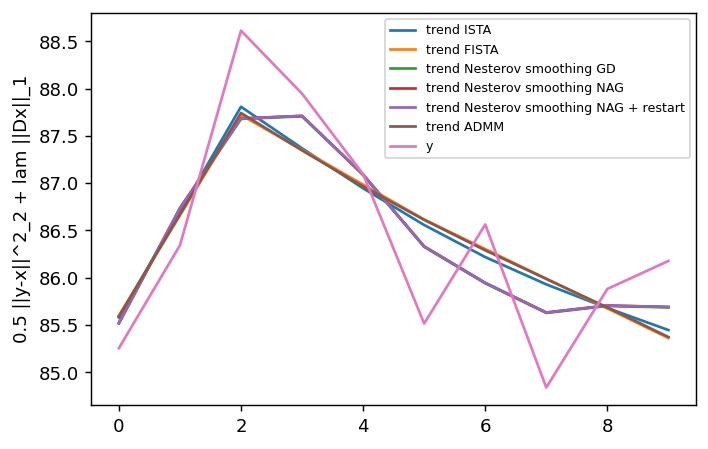

In [72]:
plt.figure(figsize = (6, 4), dpi = 130)
plt.plot(x_ista[:10], label = "trend ISTA")
plt.plot(x_fista[:10], label = "trend FISTA")
plt.plot(x_gd[:10], label = "trend Nesterov smoothing GD")
plt.plot(x_nag[:10], label = "trend Nesterov smoothing NAG")
plt.plot(x_nag_rest[:10], label = "trend Nesterov smoothing NAG + restart")
plt.plot(x_admm[:10], label = "trend ADMM")
plt.plot(y[:10], label = "y")
plt.ylabel("0.5 ||y-x||^2_2 + lam ||Dx||_1")
plt.legend(fontsize = 7)
plt.show()

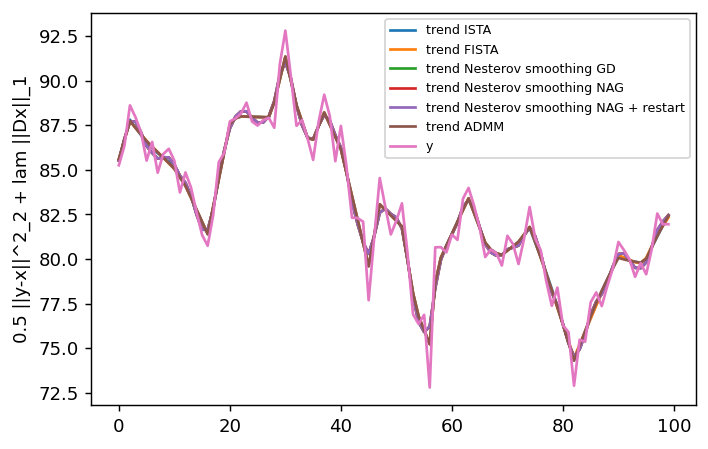

In [73]:
plt.figure(figsize = (6, 4), dpi = 130)
plt.plot(x_ista[:100], label = "trend ISTA")
plt.plot(x_fista[:100], label = "trend FISTA")
plt.plot(x_gd[:100], label = "trend Nesterov smoothing GD")
plt.plot(x_nag[:100], label = "trend Nesterov smoothing NAG")
plt.plot(x_nag_rest[:100], label = "trend Nesterov smoothing NAG + restart")
plt.plot(x_admm[:100], label = "trend ADMM")
plt.plot(y[:100], label = "y")
plt.ylabel("0.5 ||y-x||^2_2 + lam ||Dx||_1")
plt.legend(fontsize = 7)
plt.show()

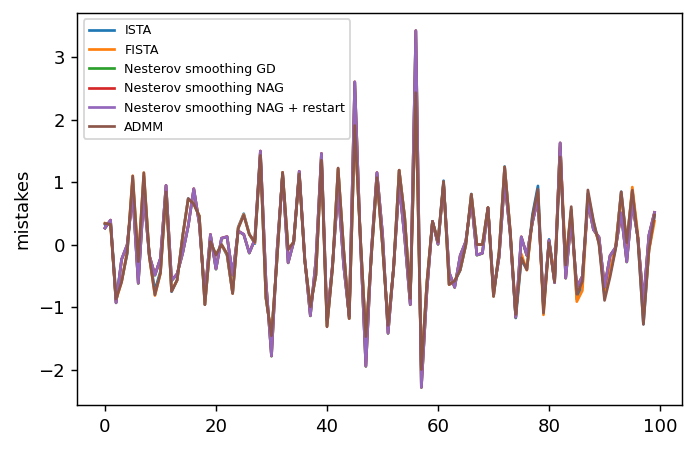

In [79]:
plt.figure(figsize = (6, 4), dpi = 130)
plt.plot(x_ista[:100] - y[:100], label = "ISTA")
plt.plot(x_fista[:100]- y[:100], label = "FISTA")
plt.plot(x_gd[:100]- y[:100], label = "Nesterov smoothing GD")
plt.plot(x_nag[:100]- y[:100], label = "Nesterov smoothing NAG")
plt.plot(x_nag_rest[:100]- y[:100], label = "Nesterov smoothing NAG + restart")
plt.plot(x_admm[:100]- y[:100], label = "ADMM")
plt.ylabel("mistakes")
plt.legend(fontsize = 7)
plt.show()

Итог: С помощью представленных алгоритмов удалось приблизить исходный временной ряд цен без временного лага. Заметим, что для корректности приближения исходных данных для методов, основаннных на сглаживании, пришлось взять параметр lambda гораздо больше, чем для остальных. Все остальные параметры для всех эксперименотв одинаковы. Поэтому будем сравнивать методы, основаннные на сглаживании, отдельно от остальных. Среди этих алгоритмов быстрее всего сходится метод с использованием рестартов, как и предполагалось. Также он сильнее скоррелирован с исходным временным рядом. Из остальных методов лучше всего справились FISTA и ADMM согласно графику сходимости. А сами графики приближений временного ряда практически неотличимы.

# ADMM (15 pts)

Техника сглаживания оказала достаточно большое влияние на развитие методов восстановления тензоров (matrix completion problem является частным случаем). 

Рассмотрим задачу восстановления матрицы $Y$. Мы наблюдаем только небольшой набор элементов матрицы $Y$, множество индексов известных элементов обозначим через $E$. То есть мы знаем $Y_{ij}$ для всех $(i,j) \in E$, и не знаем $Y_{ij}$ для всех $(i,j) \notin E$.

Понятно, что без наличия какой-либо дополнительной информации о матрице $Y$ эта постановка является тривиальной: любая матрица $X$, для которой выполнено $X_{i,j} = Y_{i,j}, \quad (i,j) \in E$ является разумным ответом. Таких матриц бесконечно много. Соответственно задача восстановления матриц обычно рассматривается как частный случай задачи приближения матрицы, а критерий качества (целевая функция) говорит не столько о близости $X$ к $Y$, сколько о полезных свойствах матрицы $X$ (этим свойствам матрица $Y$ может и не обладать).

Одна из самых популярных постановок, с которой Вы наверняка сталкивались, например, строя рекомендательные системы, является задача о поиске наилучшего приближения заданной матрицы матрицей малого ранга:

$$
\begin{align*}
& \min_{X} rk(X) \\
& X_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}
$$
Как известно, в общем случае эта задача является NP-трудной.

Для того, чтобы обойти это припятствие ранк матрицы аппроксимируется той или иной выпуклой функцией от матрицы $X$.

Опять же стандартным выбором является переход к постановке задачи с использованием 1-й нормы Шаттена (она же trace norm).

$\textbf{RegMC problem}$

$$
\begin{align*}
& \min_{X}\|X \|_* \\
& X_{i,j} = Y_{i,j}, \quad (i,j) \in E\\
\end{align*}
$$

Здесь $X_* = \sum \sigma_i(X)$. 


1. (1 pts) Сведите задачу RegMC к виду, пригодному для решения алгоритмом ADMM
2. (5 pts) Выпишите аналитическую запись всех шагов вычисления алгоритма ADMM для численного решения задачи, полученной в пункте 1.
3. (2 pts) Реализуйте метод ADMM. 
4. (1 pts) Сведите задачу RegMC к виду, пригодному для решения техникой сглаживания
5. (5 pts) Реализуйте алгоритм быстрого градиентного спуска+техника сглаживания для задачи из п.4
6. (1 pts) Протестируйте алгоритм из п.3 на тестовых данных и сравните результаты. 
От Вас требуется сравнить скорость сходимости методов на тестовых данных. Предложите метод сравнения и обоснуйте свой выбор.





# 1. 

$$
\min_X Tr \Big(\sqrt {X^* X} \Big)  
$$
$$
X @ H = M,\ где\ M_{i,j} = \begin{cases} 
Y_{i,j},\ (i,j) \in E \\
0,\ (i,j) \notin E
\end{cases} \ H_{i,j} = \begin{cases} 
1,\ (i,j) \in E \\
0,\ (i,j) \notin E
\end{cases}.
$$
@ - покомпонентное умножение